In [8]:
!git clone https://github.com/lyeeonardo/Design2025.git
%cd /content/Design2025/titanic
!ls

Cloning into 'Design2025'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 57.10 KiB | 7.14 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/Design2025/titanic
Design2025  submission.csv  test.csv  train.csv


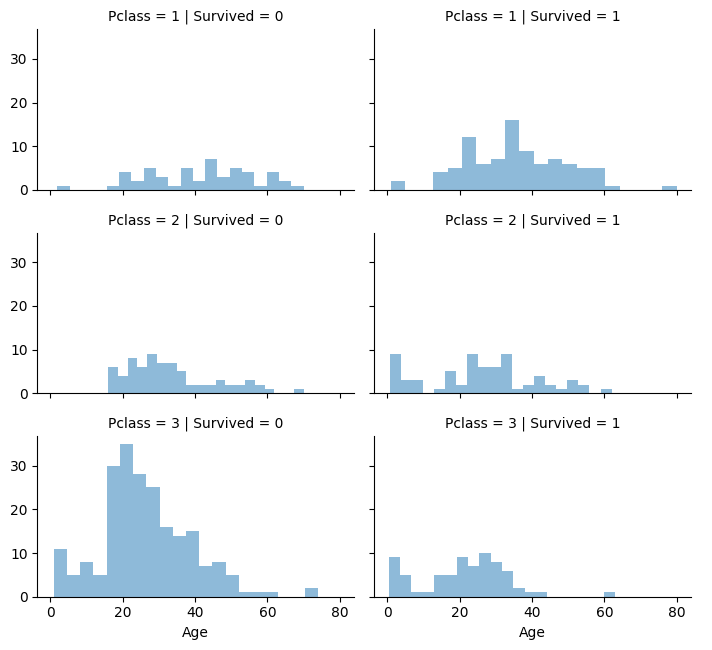

In [9]:
# ============================================================
# Section 1: Load and Visualize Data
# ============================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load training and test datasets.
train_df = pd.read_csv('train.csv')
serving_df = pd.read_csv('test.csv')  # Renamed to 'serving_df' to avoid conflict.

# Visualize the distribution of Age for each combination of Survived and Pclass.
# This helps understand how age is distributed among different classes and outcomes.
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()
plt.show()

In [19]:
print(train_df.head())

   PassengerId  Survived  Pclass                                Name     Sex  \
0          332         0       1                 Partner, Mr. Austen    male   
1          734         0       2          Berriman, Mr. William John    male   
2          383         0       3                  Tikkanen, Mr. Juho    male   
3          705         0       3             Hansen, Mr. Henrik Juul    male   
4          814         0       3  Andersson, Miss. Ebba Iris Alfrida  female   

    Age  SibSp  Parch             Ticket     Fare Cabin Embarked  
0  45.5      0      0             113043  28.5000  C124        S  
1  23.0      0      0              28425  13.0000   NaN        S  
2  32.0      0      0  STON/O 2. 3101293   7.9250   NaN        S  
3  26.0      1      0             350025   7.8542   NaN        S  
4   6.0      4      2             347082  31.2750   NaN        S  


In [18]:
# ============================================================
# Section 2: Data Preprocessing
# ============================================================
def preprocess(df):
    """
    Applies the following transformations:
      - Normalizes the 'Name' column by removing extraneous punctuation.
      - Extracts the ticket number (last token) from the 'Ticket' column.
      - Extracts the ticket item (all tokens except the last) from the 'Ticket' column.
      - Fills NaN values appropriately.
    """
    df = df.copy()

    # Remove commas, parentheses, brackets, periods, and quotes from names.
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in str(x).split(" ")])

    # Extract the ticket number (the last element in the ticket string).
    def ticket_number(x):
        return str(x).split(" ")[-1] if pd.notna(x) else "NONE"

    # Extract the ticket item (all elements except the last).
    def ticket_item(x):
        items = str(x).split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[:-1])

    # Apply transformations
    print(df["Name"].head())
    print("-----------------------")
    df["Name"] = df["Name"].apply(normalize_name)
    print(df["Name"].head())
    print("-----------------------")
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)

    df = df.assign(
        Age=df["Age"].fillna(df["Age"].median()),  # Fill missing Age with median
        Fare=df["Fare"].fillna(df["Fare"].median()),  # Fill missing Fare with median
        Embarked=df["Embarked"].fillna(df["Embarked"].mode()[0]),  # Fill missing Embarked with mode
        Cabin=df["Cabin"].fillna("Unknown"),  # Fill missing Cabin with "Unknown"
        Ticket_number=df["Ticket_number"].fillna("NONE"),
        Ticket_item=df["Ticket_item"].fillna("NONE")
    )

    return df

# Preprocess both the training and serving datasets.
preprocessed_train_df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

# Display the first 5 rows of the preprocessed training data.
print(preprocessed_train_df.head(5))

# Define the list of input features for model training.
# Exclude 'PassengerId', 'Ticket', and 'Survived' (target) from the feature list.
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
print("-----------------------")
print(f"Input features: {input_features}")


0                   Partner, Mr. Austen
1            Berriman, Mr. William John
2                    Tikkanen, Mr. Juho
3               Hansen, Mr. Henrik Juul
4    Andersson, Miss. Ebba Iris Alfrida
Name: Name, dtype: object
-----------------------
0                   Partner Mr Austen
1            Berriman Mr William John
2                    Tikkanen Mr Juho
3               Hansen Mr Henrik Juul
4    Andersson Miss Ebba Iris Alfrida
Name: Name, dtype: object
-----------------------
0    Moubarek, Master. Halim Gonios ("William George")
1               Kvillner, Mr. Johan Henrik Johannesson
2                          Alhomaki, Mr. Ilmari Rudolf
3                    Harper, Miss. Annie Jessie "Nina"
4                          Nicola-Yarred, Miss. Jamila
Name: Name, dtype: object
-----------------------
0    Moubarek Master Halim Gonios William George
1           Kvillner Mr Johan Henrik Johannesson
2                      Alhomaki Mr Ilmari Rudolf
3                  Harper Miss Annie J

In [11]:
# ============================================================
# Section 3: Model Training
# ============================================================
# Prepare the feature matrix X and target vector y.
X = preprocessed_train_df[input_features]
y = preprocessed_train_df["Survived"]

# For simplicity, convert categorical variables into dummy/indicator variables.
# This step converts text features (e.g., 'Name', 'Sex', 'Cabin', etc.) to numerical format.
X = pd.get_dummies(X)

# Store the training columns for later use in model inference.
train_columns = X.columns

# Split the preprocessed training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a simple logistic regression classifier.
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate model performance on the validation set.
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")



Validation Accuracy: 0.8252


In [12]:
# ============================================================
# Section 4: Model Inference and Submission File Creation
# ============================================================
# Prepare the serving (test) data using the same input features.
X_serving = preprocessed_serving_df[input_features]
X_serving = pd.get_dummies(X_serving)

# Align the serving data columns with the training data.
# This ensures that any missing dummy columns in the test set are filled with zeros.
X_serving = X_serving.reindex(columns=train_columns, fill_value=0)

# Use the trained model to predict outcomes on the test dataset.
serving_predictions = clf.predict(X_serving)

# Create a submission DataFrame with PassengerId and the predicted Survived values.
submission_df = pd.DataFrame({
    'PassengerId': preprocessed_serving_df['PassengerId'],
    'Survived': serving_predictions
})

# Save the submission to a CSV file.
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file.
print(submission_df.head())

   PassengerId  Survived
0          710         0
1          440         0
2          841         0
3          721         1
4           40         1
